# **Named entity recognition**

# **Setting up the Environment**

In [1]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate seqeval -U -qq
    base_folder = Path("/content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW6")



from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorForTokenClassification, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel, Sequence
import evaluate


import wandb

import numpy as np
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import textwrap
import torch
import gc


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'Data'
model_folder = base_folder/'Models'
model_folder.mkdir(exist_ok=True)
data_folder.mkdir(exist_ok=True)

In [ ]:
def print_wrap(text, d):
    # If the text is a list, convert it to a string
    if isinstance(text, list):
        # Convert None values to a default string (e.g., "None" or an empty string)
        text = ' '.join(str(item) if item is not None else "None" for item in text)

    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

# **Function to Load Dataset**

In [ ]:
def load_dataset_from_hf(name_of_the_datacard):
  data = load_dataset(name_of_the_datacard)
  return data



# **Function to Create smaller subset**

In [ ]:
#pass whole dataset
def get_small_data(data):
  train_split_small = data['train'].shuffle(seed=42).select(range(5000))
  val_split_small = data['validation'].shuffle(seed=42).select(range(1000))
  test_split_small = data['test'].shuffle(seed=42).select(range(1000))
  # combine train, val splits into one dataset
  train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})
  # create test dataset from test split
  test_subset= DatasetDict({'test': test_split_small})
  return train_split_small,val_split_small,test_split_small,train_val_subset,test_subset


# **Map Targets to integers**

In [ ]:
#Whole dataset
def id2label_label2id(data):
  class_names = data['train'].features['ner_tags'].feature.names
  id2label = {}
  for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
  label2id = {}
  for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
  return id2label,label2id






# **Function to Align labels**

In [ ]:
def align_targets(labels, word_ids):

    # Dictionary mapping from B- tag indices to corresponding I- tag indices
    begin2inside = {1:2, 3:4, 5:6, 7:8}

    aligned_labels = []
    last_id = None

    for word_id in word_ids:
        # Check if the current token is a special token (like [CLS], [SEP] etc.)
        if word_id is None:
            label = -100
        # Check if it's a new word (i.e., not part of the previous word)
        elif word_id != last_id:
            label = labels[word_id]
        else:  # Token is part of the same word as the previous token
            label = labels[word_id]
            # If the label starts with a B-, we transition it to the corresponding I- tag
            if label in begin2inside:
                label = begin2inside[label]

        # Add the label to the aligned list
        aligned_labels.append(label)

        # Update the last_id for the next iteration
        last_id = word_id

    return aligned_labels

# **Function for Tokenization**

In [ ]:
def get_tokenized_dataset(checkpoint, dataset):
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  def tokenize_fn(batch):
    # Tokenize the 'tokens' from the batch. This returns various fields like 'input_ids', 'attention_mask', etc.
    # 'is_split_into_words=True' indicates the input is already tokenized into words.
    # 'truncation=True' ensures sequences longer than the model's max length are truncated.
    tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)

    # Extract the original labels/tags from the batch.
    labels_batch = batch['ner_tags']

    # This list will store the labels aligned with the tokenized input.
    aligned_labels_batch = []

    # Iterate over each example in the batch.
    for i, labels in enumerate(labels_batch):
        # Obtain the word IDs for the tokenized example. This helps in aligning the original labels with the tokens.
        word_ids = tokenized_inputs.word_ids(i)

        # Align the original labels with the tokenized example and append to the aligned_labels_batch list.
        aligned_labels_batch.append(align_targets(labels, word_ids))

    # The HuggingFace trainer expects the labels for token classification tasks to be under the key 'labels'.
    # Store the aligned labels in the 'labels' key of the tokenized_inputs dictionary.
    tokenized_inputs['labels'] = aligned_labels_batch

    return tokenized_inputs
  tokenized_dataset = dataset.map(tokenize_fn, batched=True)
  tokenized_dataset = tokenized_dataset.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])
  tokenized_dataset.set_format(type='torch')
  return tokenized_dataset



# **Function to Create Datasets**

In [ ]:
def setup_dataset(name_of_the_datacard):
  #loading the dataset from hugging face
  data = load_dataset_from_hf(name_of_the_datacard)

  train_dataset = data['train']
  test_dataset = data['test']
  #splitting the dataset and creating a small subset of the dataset
  train_split_small,val_split_small,test_split_small,train_val_subset,test_subset = get_small_data(data)
  #id2label,label2id = id2label_label2id(data)

  return train_val_subset,train_dataset,test_dataset




# **Function to Initialize Model**

In [ ]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)
    return model

# **Function to Compute Metrics**

In [ ]:
seqeval_metric = evaluate.load('seqeval')
def compute_metrics(logits_and_labels):

    # Separate logits and labels from the input tuple
    logits, true_labels = logits_and_labels

    # Obtain predicted label indices by selecting the label with the highest logit value for each token
    predicted_indices = np.argmax(logits, axis=-1)  # Shape: (batch_size, sequence_length)

    # Convert label indices to their string representation, ignoring special tokens (label index = -100)
    string_true_labels = [[class_names[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

    # Convert predicted indices to their string representation, but only for tokens where the true label isn't -100
    string_predictions = [
        [class_names[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
        for pred_sequence, true_sequence in zip(predicted_indices, true_labels)
    ]

    # Compute the metrics using seqeval
    metrics_results = seqeval_metric.compute(predictions=string_predictions, references=string_true_labels)

    return {
        'precision': metrics_results['overall_precision'],
        'recall': metrics_results['overall_recall'],
        'f1': metrics_results['overall_f1'],
        'accuracy': metrics_results['overall_accuracy']
    }

# **Function to set Trainer**

In [ ]:
def get_trainer(model, training_args, train_dataset, eval_dataset, compute_metrics, tokenizer, data_collator):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator= data_collator
    )
    return trainer

# **Function to plot confusion matrix**

In [ ]:
def log_and_plot_confusion_matrix(trainer, tokenized_val_dataset, class_names):
  valid_output = trainer.predict(tokenized_val_dataset["val"])
  # Convert the logits (raw prediction scores) from the valid_output object into class predictions.
  # For each input, pick the class with the highest logit as the predicted class.
  # Also, extract the true label IDs from valid_output and store them as an array for further analysis.
  valid_predictions = np.argmax(valid_output.predictions, axis=2)
  valid_labels = np.array(valid_output.label_ids)

  # 2. Filter out any tokens with label -100 (typically used for padding or special tokens)
  mask = valid_labels != -100
  filtered_predictions = valid_predictions[mask]
  filtered_labels = valid_labels[mask]
  #  Generate the confusion matrix
  cm = confusion_matrix(filtered_labels, filtered_predictions,normalize='true')

  # Plotting the confusion matrix
  plt.figure(figsize=(8, 6))
  ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  # Ensure x-labels are vertical
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

  # Ensure y-labels are horizontal
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()


# **Function to free memory**

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# **Function to tokenize dataset and, train and eval models**

In [ ]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder,
                             class_names, train_val_subset, compute_metrics):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_course_fall_2023-HW6-Part-C-Colab

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder / "Models" / "NER-HW6c-exp1"/checkpoint
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 3. Get Tokenized Dataset and Data Collator
    train_val_tokenized_dataset = get_tokenized_dataset(checkpoint, train_val_subset)

    # 4. Initialize Model and Tokenizer
    model = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # 5. Initialize Trainer
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer,
                                                       padding=True,
                                                       label_pad_token_id=-100,
                                                       return_tensors='pt')

    trainer = get_trainer(model, training_args, train_val_tokenized_dataset['train'],
                          train_val_tokenized_dataset['val'], compute_metrics, tokenizer, data_collator)

    # 6. Train and Evaluate
    trainer.train()
    trainer.evaluate(train_val_tokenized_dataset['val'])

    # 7. Log Metrics and Plot
    log_and_plot_confusion_matrix(trainer, train_val_tokenized_dataset, class_names)

    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()

# **Initial Training Arguments**

In [ ]:
# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)

# **Experiments**

In [ ]:
class_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
name_of_the_datacard= 'conll2003'
train_val_subset, train_dataset, test_dataset = setup_dataset(name_of_the_datacard)

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

# **Experiment 1 : distilbert-base-uncased and learning rate = 0.00002**

In [ ]:
checkpoint = 'distilbert-base-uncased'
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{name_of_the_datacard}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1711: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: WANDB_PROJECT=nlp_course_fall_2023-HW6-Part-C-Colab


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.244500,0.828026,0.000000,0.000000,0.000000,0.792906
40,0.719000,0.558639,0.204893,0.037347,0.063178,0.822588
60,0.499000,0.395461,0.472801,0.455407,0.463941,0.876428
80,0.362500,0.305699,0.528974,0.554627,0.541497,0.913741
100,0.290700,0.241485,0.587293,0.633779,0.609651,0.929267
120,0.246800,0.201481,0.625000,0.680045,0.651361,0.939845
140,0.231300,0.174088,0.691116,0.745819,0.717426,0.951371
160,0.222800,0.155965,0.745540,0.792085,0.768108,0.956108
180,0.182000,0.134751,0.783598,0.825530,0.804017,0.963423
200,0.153500,0.124215,0.786842,0.833333,0.809421,0.965476


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

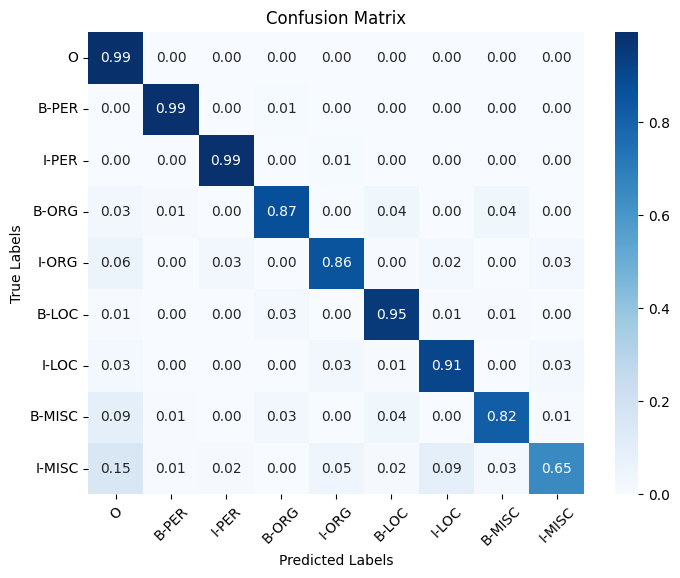

The best model was saved at step 600.


eval/accuracy,▁▁▆▆▇▇▇█████████████▁▂▆▇▇▇██████████████
eval/f1,▁▁▆▆▇▇▇█████████████▁▂▅▆▇▇██████████████
eval/loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▁▆▆▆▇▇▇████████████▁▃▅▆▇▇██████████████
eval/recall,▁▁▆▆▇▇██████████████▁▁▅▆▇███████████████
eval/runtime,▁▂▁▂▂▅▁▄▁▃▇▂▂▁▂▃▁▁▃▂█▂▁▁▁▁▁▁▂▁▁▁▂▃▁▂▂▁▁▁
eval/samples_per_second,█▆▇▆▅▂▇▃▇▅▁▆▆▇▆▄▇▇▅▆▁▆█▇▇█▇▇▆▇▇▇▅▄▇▅▅▇▇▇
eval/steps_per_second,█▆▇▆▅▂▇▃▇▅▁▆▆▇▆▄▇▇▅▆▁▆█▇▇█▇▇▆▇▇▇▅▄▇▅▅▇▇▇
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/learning_rate,██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁██▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

# **Experiment 2 : distilbert-base-uncased, learning rate = 0.0002**

In [ ]:
checkpoint = 'distilbert-base-uncased'
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{name_of_the_datacard}' # Update the run_name
training_args_dict['learning_rate'] = 2e-4
new_training_args = TrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1711: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


env: WANDB_PROJECT=nlp_course_fall_2023-HW6-Part-C-Colab


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,0.696400,0.273604,0.549089,0.604794,0.575597,0.917478
40,0.251100,0.165958,0.717597,0.759197,0.737811,0.950897
60,0.175200,0.147133,0.761234,0.783724,0.772315,0.955160
80,0.160000,0.128048,0.759042,0.830546,0.793186,0.962581
100,0.149100,0.109427,0.804555,0.846711,0.825095,0.969054
120,0.143800,0.131693,0.773429,0.837235,0.804069,0.960002
140,0.156400,0.115755,0.833516,0.848384,0.840884,0.968686
160,0.174300,0.105378,0.778680,0.855072,0.815090,0.965791
180,0.128400,0.100839,0.797613,0.856745,0.826122,0.969423
200,0.134700,0.092298,0.848518,0.877369,0.862702,0.974159


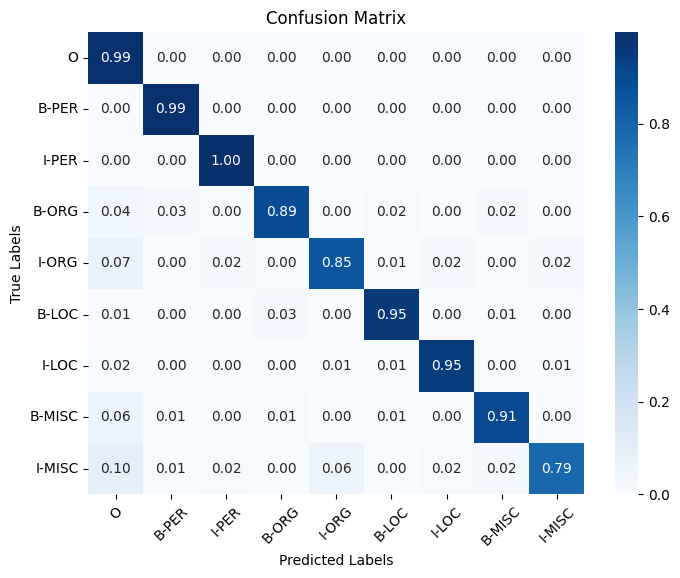

The best model was saved at step 600.


eval/accuracy,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇█████████████
eval/f1,▁▄▅▆▆▆▇▆▆▇▇▇▇▇▇▇████████████████
eval/loss,█▄▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
eval/precision,▁▄▅▅▆▆▇▆▆▇▇▇▇▇▇█████████████████
eval/recall,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████
eval/runtime,▃▅▁▇▁▁▁▁▂▁▅▁▆▁▅▅▁▁█▁▆▁▅▃▁▅▂▆▂▂▂▂
eval/samples_per_second,▅▃█▂▇███▇▇▄█▃▇▃▃█▇▁█▃▇▃▅▇▃▇▃▇▇▇▇
eval/steps_per_second,▅▃█▂▇███▇▇▄█▃▇▃▃█▇▁█▃▇▃▅▇▃▇▃▇▇▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

# **Conclusion:**
Increasing the learning rate from 2e-5 to 2e-4 has increased the validation set's f1 score, precision and recall

In [2]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [3]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW6/Pooja_Akkaladevi_HW6c.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW6/Pooja_Akkaladevi_HW6c.ipynb to pdf
[NbConvertApp] Support files will be in Pooja_Akkaladevi_HW6c_files/
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW6c_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW6c_files
[NbConvertApp] Writing 101366 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 190859 bytes to /content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW6/Pooja_Akkaladevi_HW6c.pdf
